In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression




# === 1. Загрузка данных ===
df = pd.read_csv('./Airline Quality Ratings.csv',header=0, delimiter=",")














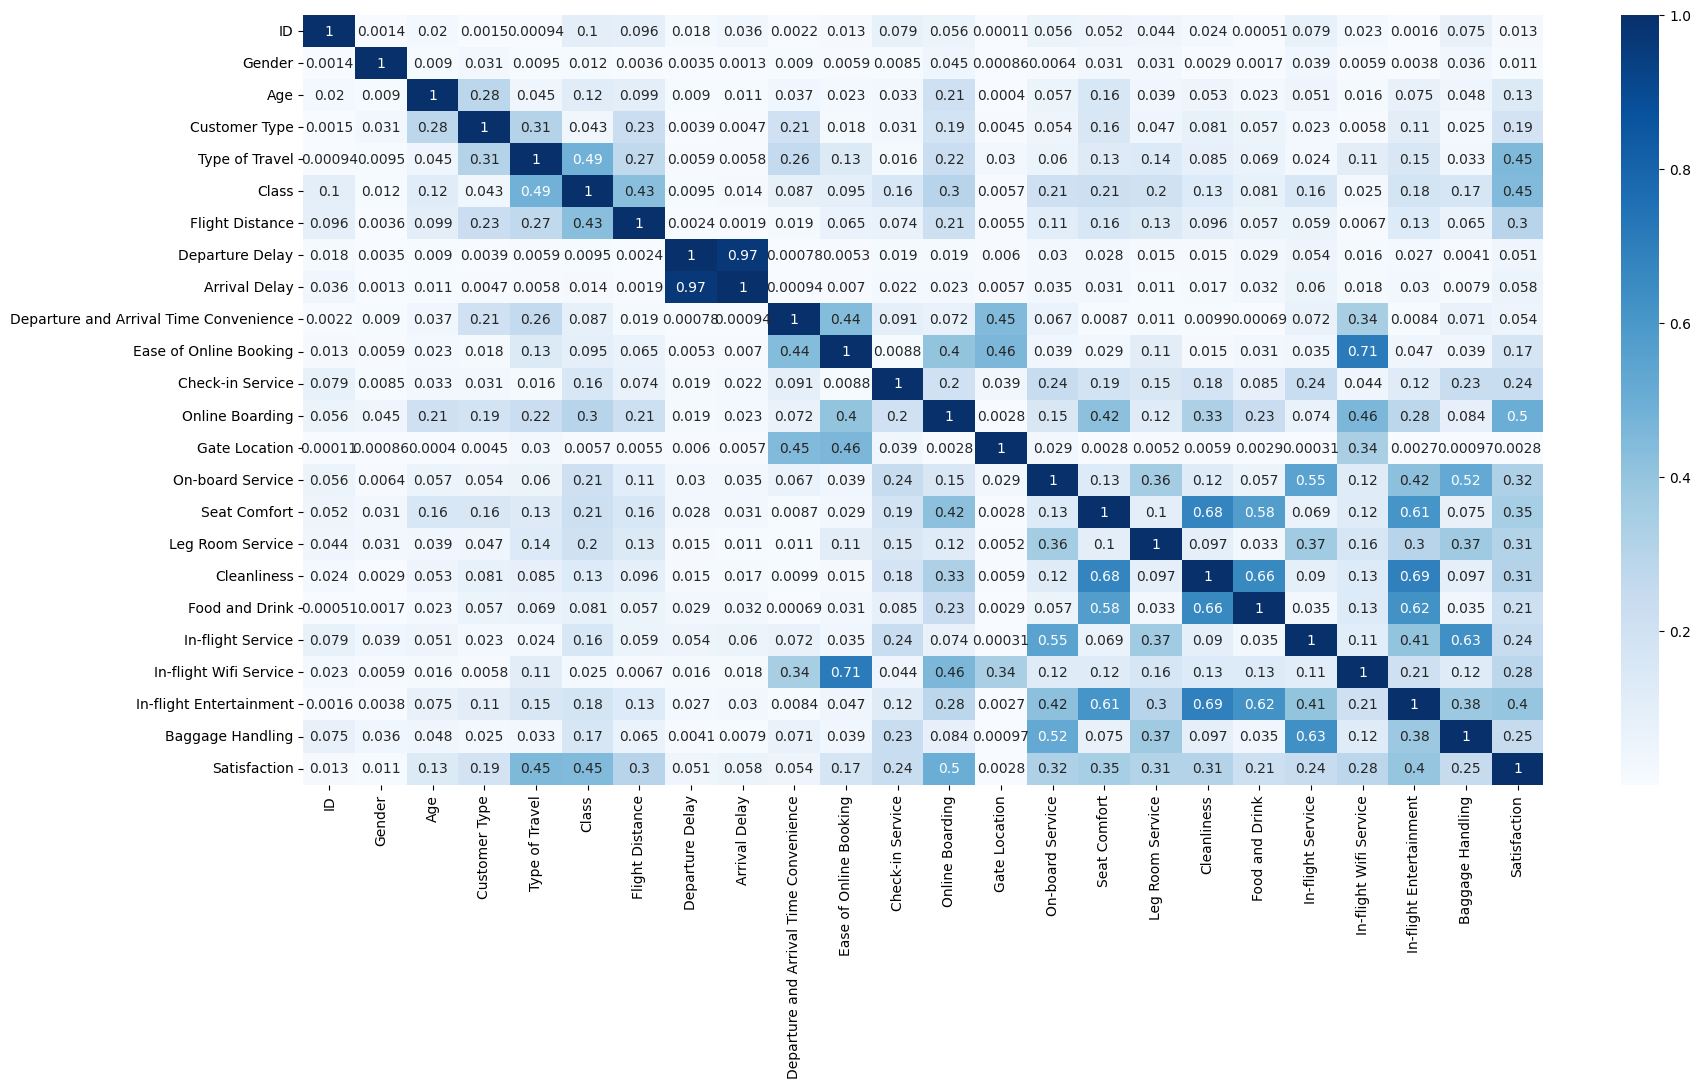

In [42]:


df_encoded = df.copy()
for col in df_encoded.select_dtypes(include="object").columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

plt.figure(figsize=(20, 10))
corr = df_encoded.corr().abs()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.show()


In [66]:
# === 2. Формируем новую целевую переменную (1–5) ===

import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 1) Определяем сервисные столбцы (оценки 1–5)
service_cols = [
    "Departure and Arrival Time Convenience",
    "Ease of Online Booking",
    "Check-in Service",
    "Online Boarding",
    "Gate Location",
    "On-board Service",
    "Seat Comfort",
    "Leg Room Service",
    "Cleanliness",
    "Food and Drink",
    "In-flight Service",
    "In-flight Wifi Service",
    "In-flight Entertainment",
    "Baggage Handling"
]

# 2) Учим логистическую регрессию на бинарной цели, чтобы получить ДАННЫЕ-ЗАВИСИМЫЕ веса
# Используем только сервисные признаки, чтобы веса отражали их вклад
preprocess_services = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_services = df[service_cols].copy()
y_binary = (df["Satisfaction"] == "Satisfied").astype(int)  # 1 = Satisfied, 0 = Neutral/Dissatisfied

# Преобразуем сервисные фичи
X_services_proc = preprocess_services.fit_transform(X_services)

# Учим логистическую регрессию
lr = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced"
)
lr.fit(X_services_proc, y_binary)

# 3) Достаём веса из модели и нормализуем их
coef = lr.coef_.ravel()              # коэффициенты при стандартизированных сервисных фичах
weights_raw = np.abs(coef)           # берём модуль: сила влияния
weights = weights_raw / (weights_raw.sum() + 1e-12)  # нормируем, чтобы сумма = 1

# 4) Считаем взвешенный скор для каждой строки
# Важно: используем те же имьютер и скейлер, что и при обучении
Z = X_services_proc                  # стандартизированные сервисные фичи
weighted_score = Z.dot(weights)      # S = sum w_i * z(x_i)
df["weighted_service_score"] = weighted_score

# 5) Вычисляем пороги внутри групп Satisfaction
nd_mask = df["Satisfaction"] == "Neutral or Dissatisfied"
sat_mask = df["Satisfaction"] == "Satisfied"

# Пороги по квантилям в каждой группе
q_nd = np.quantile(df.loc[nd_mask, "weighted_service_score"], [0.33, 0.66]) if nd_mask.any() else [0, 0]
q_sat = np.quantile(df.loc[sat_mask, "weighted_service_score"], [0.60]) if sat_mask.any() else [0]

q_nd33, q_nd66 = q_nd
q_sat60 = q_sat[0]

# 6) Маппинг в 1–5 с якорем на бинарной метке и внутренними порогами по взвешенному скору
def map_to_5(row):
    base = row["Satisfaction"]
    s = row["weighted_service_score"]

    if base == "Neutral or Dissatisfied":
        if s <= q_nd33: return 1
        elif s <= q_nd66: return 2
        else: return 3
    else:  # Satisfied
        if s < q_sat60: return 4
        else: return 5

df["Satisfaction_5"] = df.apply(map_to_5, axis=1).astype(int)

print("Распределение новых классов (1–5):")
print(df["Satisfaction_5"].value_counts().sort_index())

# 7) (Необязательно) Посмотреть веса по параметрам для интерпретации
weights_df = pd.DataFrame({"feature": service_cols, "weight": weights})
weights_df = weights_df.sort_values("weight", ascending=False)
print("\nВеса сервисных параметров (сумма = 1):")
print(weights_df.to_string(index=False))
service_cols = [
    "Departure and Arrival Time Convenience",
    "Ease of Online Booking",
    "Check-in Service",
    "Online Boarding",
    "Gate Location",
    "On-board Service",
    "Seat Comfort",
    "Leg Room Service",
    "Cleanliness",
    "Food and Drink",
    "In-flight Service",
    "In-flight Wifi Service",
    "In-flight Entertainment",
    "Baggage Handling"
]

# Средний сервисный балл
df["service_mean"] = df[service_cols].mean(axis=1)

# Функция преобразования бинарной метки в 5 классов
def map_satisfaction(row):
    base = row["Satisfaction"]   # бинарная метка
    score = row["service_mean"]

    if base == "Neutral or Dissatisfied":
        if score <= 2: return 1
        elif score <= 3: return 2
        else: return 3
    else:  # Satisfied
        if score < 4: return 4
        else: return 5

df["Satisfaction_5"] = df.apply(map_satisfaction, axis=1)

print("Распределение новых классов:")
print(df["Satisfaction_5"].value_counts().sort_index())

Распределение новых классов (1–5):
Satisfaction_5
1    24239
2    24239
3    24974
4    33857
5    22571
Name: count, dtype: int64

Веса сервисных параметров (сумма = 1):
                               feature   weight
                       Online Boarding 0.253462
Departure and Arrival Time Convenience 0.107846
                      Leg Room Service 0.107142
                In-flight Wifi Service 0.098872
               In-flight Entertainment 0.091109
                      On-board Service 0.085563
                      Check-in Service 0.067848
                          Seat Comfort 0.047592
                Ease of Online Booking 0.047515
                         Gate Location 0.036005
                        Food and Drink 0.022304
                           Cleanliness 0.016642
                      Baggage Handling 0.014459
                     In-flight Service 0.003641
Распределение новых классов:
Satisfaction_5
1     3836
2    36749
3    32867
4    39804
5    16624
Name: coun

In [67]:
# === 3. Подготовка признаков и цели ===
y = df["Satisfaction_5"]
X = df.drop(columns=["ID", "Satisfaction", "Satisfaction_5", "service_mean"])

categorical = ["Gender", "Customer Type", "Type of Travel", "Class"]
numeric = [col for col in X.columns if col not in categorical]


In [68]:
# === 4. Предобработка ===
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

In [69]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===  Обучение ===
clf.fit(X_train, y_train)

# ===  Предсказание и оценка ===
y_pred = clf.predict(X_test)

print("\nКлассификационный отчёт:")
print(classification_report(y_test, y_pred, digits=3))


Классификационный отчёт:
              precision    recall  f1-score   support

           1      0.948     0.827     0.883       767
           2      0.926     0.960     0.943      7350
           3      0.911     0.926     0.919      6573
           4      0.942     0.918     0.930      7961
           5      0.965     0.944     0.955      3325

    accuracy                          0.933     25976
   macro avg      0.939     0.915     0.926     25976
weighted avg      0.933     0.933     0.932     25976



In [70]:
import numpy as np

# Сдвигаем метки: 1–5 → 0–4
y_shifted = y - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y_shifted, test_size=0.2, random_state=42, stratify=y_shifted
)

clf1 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    ))
])

clf1.fit(X_train, y_train)

# Предсказания (в 0–4)
y_pred_shifted = clf1.predict(X_test)

# Возвращаем обратно в 1–5
y_pred = y_pred_shifted + 1
y_test_original = y_test + 1

print("\nКлассификационный отчёт по XGBClassifier:")
print(classification_report(y_test_original, y_pred, digits=3))


Классификационный отчёт по XGBClassifier:
              precision    recall  f1-score   support

           1      0.964     0.932     0.948       767
           2      0.959     0.977     0.968      7350
           3      0.929     0.942     0.936      6573
           4      0.948     0.928     0.938      7961
           5      0.978     0.968     0.972      3325

    accuracy                          0.951     25976
   macro avg      0.956     0.949     0.952     25976
weighted avg      0.951     0.951     0.951     25976



In [73]:


categorical = ["Gender", "Customer Type", "Type of Travel", "Class"]
numeric = [col for col in X.columns if col not in categorical]


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric)
    ]
)

# Модель
clf3 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Обучение
clf3.fit(X_train, y_train)

# Предсказание
y_pred = clf3.predict(X_test)

print("\nКлассификационный отчёт по GradientBoostingClassifier:")
print(classification_report(y_test, y_pred, digits=3))


Классификационный отчёт по GradientBoostingClassifier:
              precision    recall  f1-score   support

           1      0.927     0.872     0.899       767
           2      0.915     0.946     0.930      7350
           3      0.903     0.885     0.893      6573
           4      0.896     0.896     0.896      7961
           5      0.949     0.928     0.938      3325

    accuracy                          0.910     25976
   macro avg      0.918     0.905     0.911     25976
weighted avg      0.910     0.910     0.910     25976



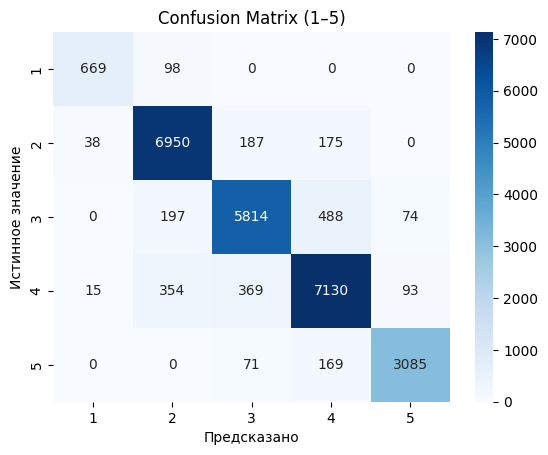

In [74]:
# === 9. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Confusion Matrix (1–5)")
plt.show()



In [75]:
# === 10. Пример вероятностей предсказания ===
proba = clf.predict_proba(X_test[:5])
print("\nКлассы модели:", clf.named_steps['classifier'].classes_)
print("Пример вероятностей для первых 5 объектов:\n", proba)



Классы модели: [1 2 3 4 5]
Пример вероятностей для первых 5 объектов:
 [[0.     0.135  0.8525 0.0125 0.    ]
 [0.07   0.1225 0.     0.8075 0.    ]
 [0.     0.     0.     0.99   0.01  ]
 [0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.    ]]
